In [4]:
import os
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import re
from hashlib import sha1

from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler



### Problem

#### My task is to predict whether a credit card client will default or not.
#### All features are numerically encoded. (some features such as sex and marriage seem categorical features)


# Data Splitting

### I split the data into train (70%) and test (30%) portions with random_state = 76

In [5]:
df = pd.read_csv("data/UCI_Credit_Card.csv")
print(df)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=76)

# return tuples that has (# of rows, # of columns)
train_df.shape


          ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
0          1    20000.0    2          2         1   24      2      2     -1   
1          2   120000.0    2          2         2   26     -1      2      0   
2          3    90000.0    2          2         2   34      0      0      0   
3          4    50000.0    2          2         1   37      0      0      0   
4          5    50000.0    1          2         1   57     -1      0     -1   
...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
29995  29996   220000.0    1          3         1   39      0      0      0   
29996  29997   150000.0    1          3         2   43     -1     -1     -1   
29997  29998    30000.0    1          2         2   37      4      3      2   
29998  29999    80000.0    1          3         1   41      1     -1      0   
29999  30000    50000.0    1          2         1   46      0      0      0   

       PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6 

(21000, 25)

In [7]:
# count how many different education we have
train_df['EDUCATION'].value_counts()

EDUCATION
2    9789
1    7522
3    3365
5     197
4      80
6      37
0      10
Name: count, dtype: int64

# Exploratory Data Analysis (EDA)

### My task
- Summary statistics
- visualizations 
that can potentially be useful
- Summarize initial observations about the data
- Pick appropriate metric/metrics for assessment

#### The given table summarizes the central tendency, dispersion and shape of a dataset's distribution, excluding NaN values.
- count: count # of elements in each feature
- mean: find the avg
- std: standard deviation
- min: minimum value of each feature
- 25%, 50%, 75%: 25th, 50th, 75th precentiles
- max: maximum value of each feature


In [8]:
# summarize the central tendency, dispersion and shape of a dataset's distribution, excluding NaN values.
train_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,15011.587619,167563.508571,1.604381,1.843905,1.554667,35.412952,-0.012190,-0.132714,-0.168333,-0.223143,...,43039.813952,40121.889810,38623.497095,5601.265286,6.059441e+03,5204.302571,4889.281333,4782.900857,5162.918714,0.221857
std,8658.232639,129919.112502,0.488995,0.789845,0.521970,9.136302,1.121864,1.196554,1.195375,1.165490,...,63817.414980,60400.798292,59055.005208,16239.423781,2.407470e+04,16865.645456,16486.840852,15431.523094,17170.608569,0.415505
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7493.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2300.000000,1800.000000,1266.250000,1000.000000,8.200000e+02,390.000000,291.000000,257.750000,150.000000,0.000000
50%,15041.000000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,18990.000000,18091.000000,17127.000000,2112.500000,2.009000e+03,1801.500000,1500.000000,1500.000000,1500.000000,0.000000
75%,22505.750000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54740.000000,50065.250000,48950.500000,5012.000000,5.000000e+03,4531.250000,4048.500000,4078.000000,4001.000000,0.000000
max,29999.000000,800000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,706864.000000,823540.000000,568638.000000,873552.000000,1.684259e+06,889043.000000,621000.000000,426529.000000,528666.000000,1.000000


#### The given table provides informations about a DataFrame including the index dtype and columns, non-null values and memory usuage of features.


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21000 entries, 8958 to 2721
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          21000 non-null  int64  
 1   LIMIT_BAL                   21000 non-null  float64
 2   SEX                         21000 non-null  int64  
 3   EDUCATION                   21000 non-null  int64  
 4   MARRIAGE                    21000 non-null  int64  
 5   AGE                         21000 non-null  int64  
 6   PAY_0                       21000 non-null  int64  
 7   PAY_2                       21000 non-null  int64  
 8   PAY_3                       21000 non-null  int64  
 9   PAY_4                       21000 non-null  int64  
 10  PAY_5                       21000 non-null  int64  
 11  PAY_6                       21000 non-null  int64  
 12  BILL_AMT1                   21000 non-null  float64
 13  BILL_AMT2                   21000 

#### Below shows the corresponding fractions of binary feature "default.payment.next.month"

In [11]:
train_df["default.payment.next.month"].value_counts(normalize=True)

default.payment.next.month
0    0.778143
1    0.221857
Name: proportion, dtype: float64

In [15]:
from sklearn.metrics import f1_score, make_scorer, recall_score

custom_scorer = make_scorer(f1_score, average="macro")
scoring_metric = custom_scorer

# Show max values for each features
print(np.max(train_df, axis=0))

# Show  min values for each features
print(np.max(train_df, axis=0))

ID                              29999.0
LIMIT_BAL                      800000.0
SEX                                 2.0
EDUCATION                           6.0
MARRIAGE                            3.0
AGE                                79.0
PAY_0                               8.0
PAY_2                               8.0
PAY_3                               8.0
PAY_4                               8.0
PAY_5                               8.0
PAY_6                               8.0
BILL_AMT1                      746814.0
BILL_AMT2                      743970.0
BILL_AMT3                     1664089.0
BILL_AMT4                      706864.0
BILL_AMT5                      823540.0
BILL_AMT6                      568638.0
PAY_AMT1                       873552.0
PAY_AMT2                      1684259.0
PAY_AMT3                       889043.0
PAY_AMT4                       621000.0
PAY_AMT5                       426529.0
PAY_AMT6                       528666.0
default.payment.next.month          1.0


- X_train: contain all the training features excluding the target
- y_train: contain the target values for the training set
- X_test: contain all the test features excluding the target
- y_test: contain the target values for the test set.

In [17]:
# X_train will contain all the training features excluding the target,
# and y_train will contain the target values for the training set.
X_train, y_train = (
    train_df.drop(columns="default.payment.next.month"),
    train_df["default.payment.next.month"],
)


# X_test will contain all the test features excluding the target,
# and y_test will contain the target values for the test set.
X_test, y_test = (
    test_df.drop(columns="default.payment.next.month"),
    test_df["default.payment.next.month"]
)


### Computes the correlation matrix for the first 30 columns of target variable(y_train) and the feature variables("X_train") and visualize this matrix as a heatmap

- range from -1 to 1
    - correlation coefficient close to 1 (strong positive coefficient): two variables are strongly and positively related
    - correlation coefficient close to -1 (strong negative coefficient): two variables are strongly and negatively related
    - correlation coefficient close to 0 but positive (weak positive coefficient): two variables move in the same direction but the relation is weak
    - correlation coefficient close to 0 but negative (weak negative coefficient): two variables move in opposite directions but the relationship is weak
- A correlation coefficient ('r') quantifies the degree to which two variables are linearly related
- darker blue: typically indicate stronger correlations, whether positive or negative.
- lighter blue: indicate weaker correlations
- A value close to 1 indicates a strong positive linear relationship
    - strong positive linear relationship: when X increases, Y increases
    

<Axes: >

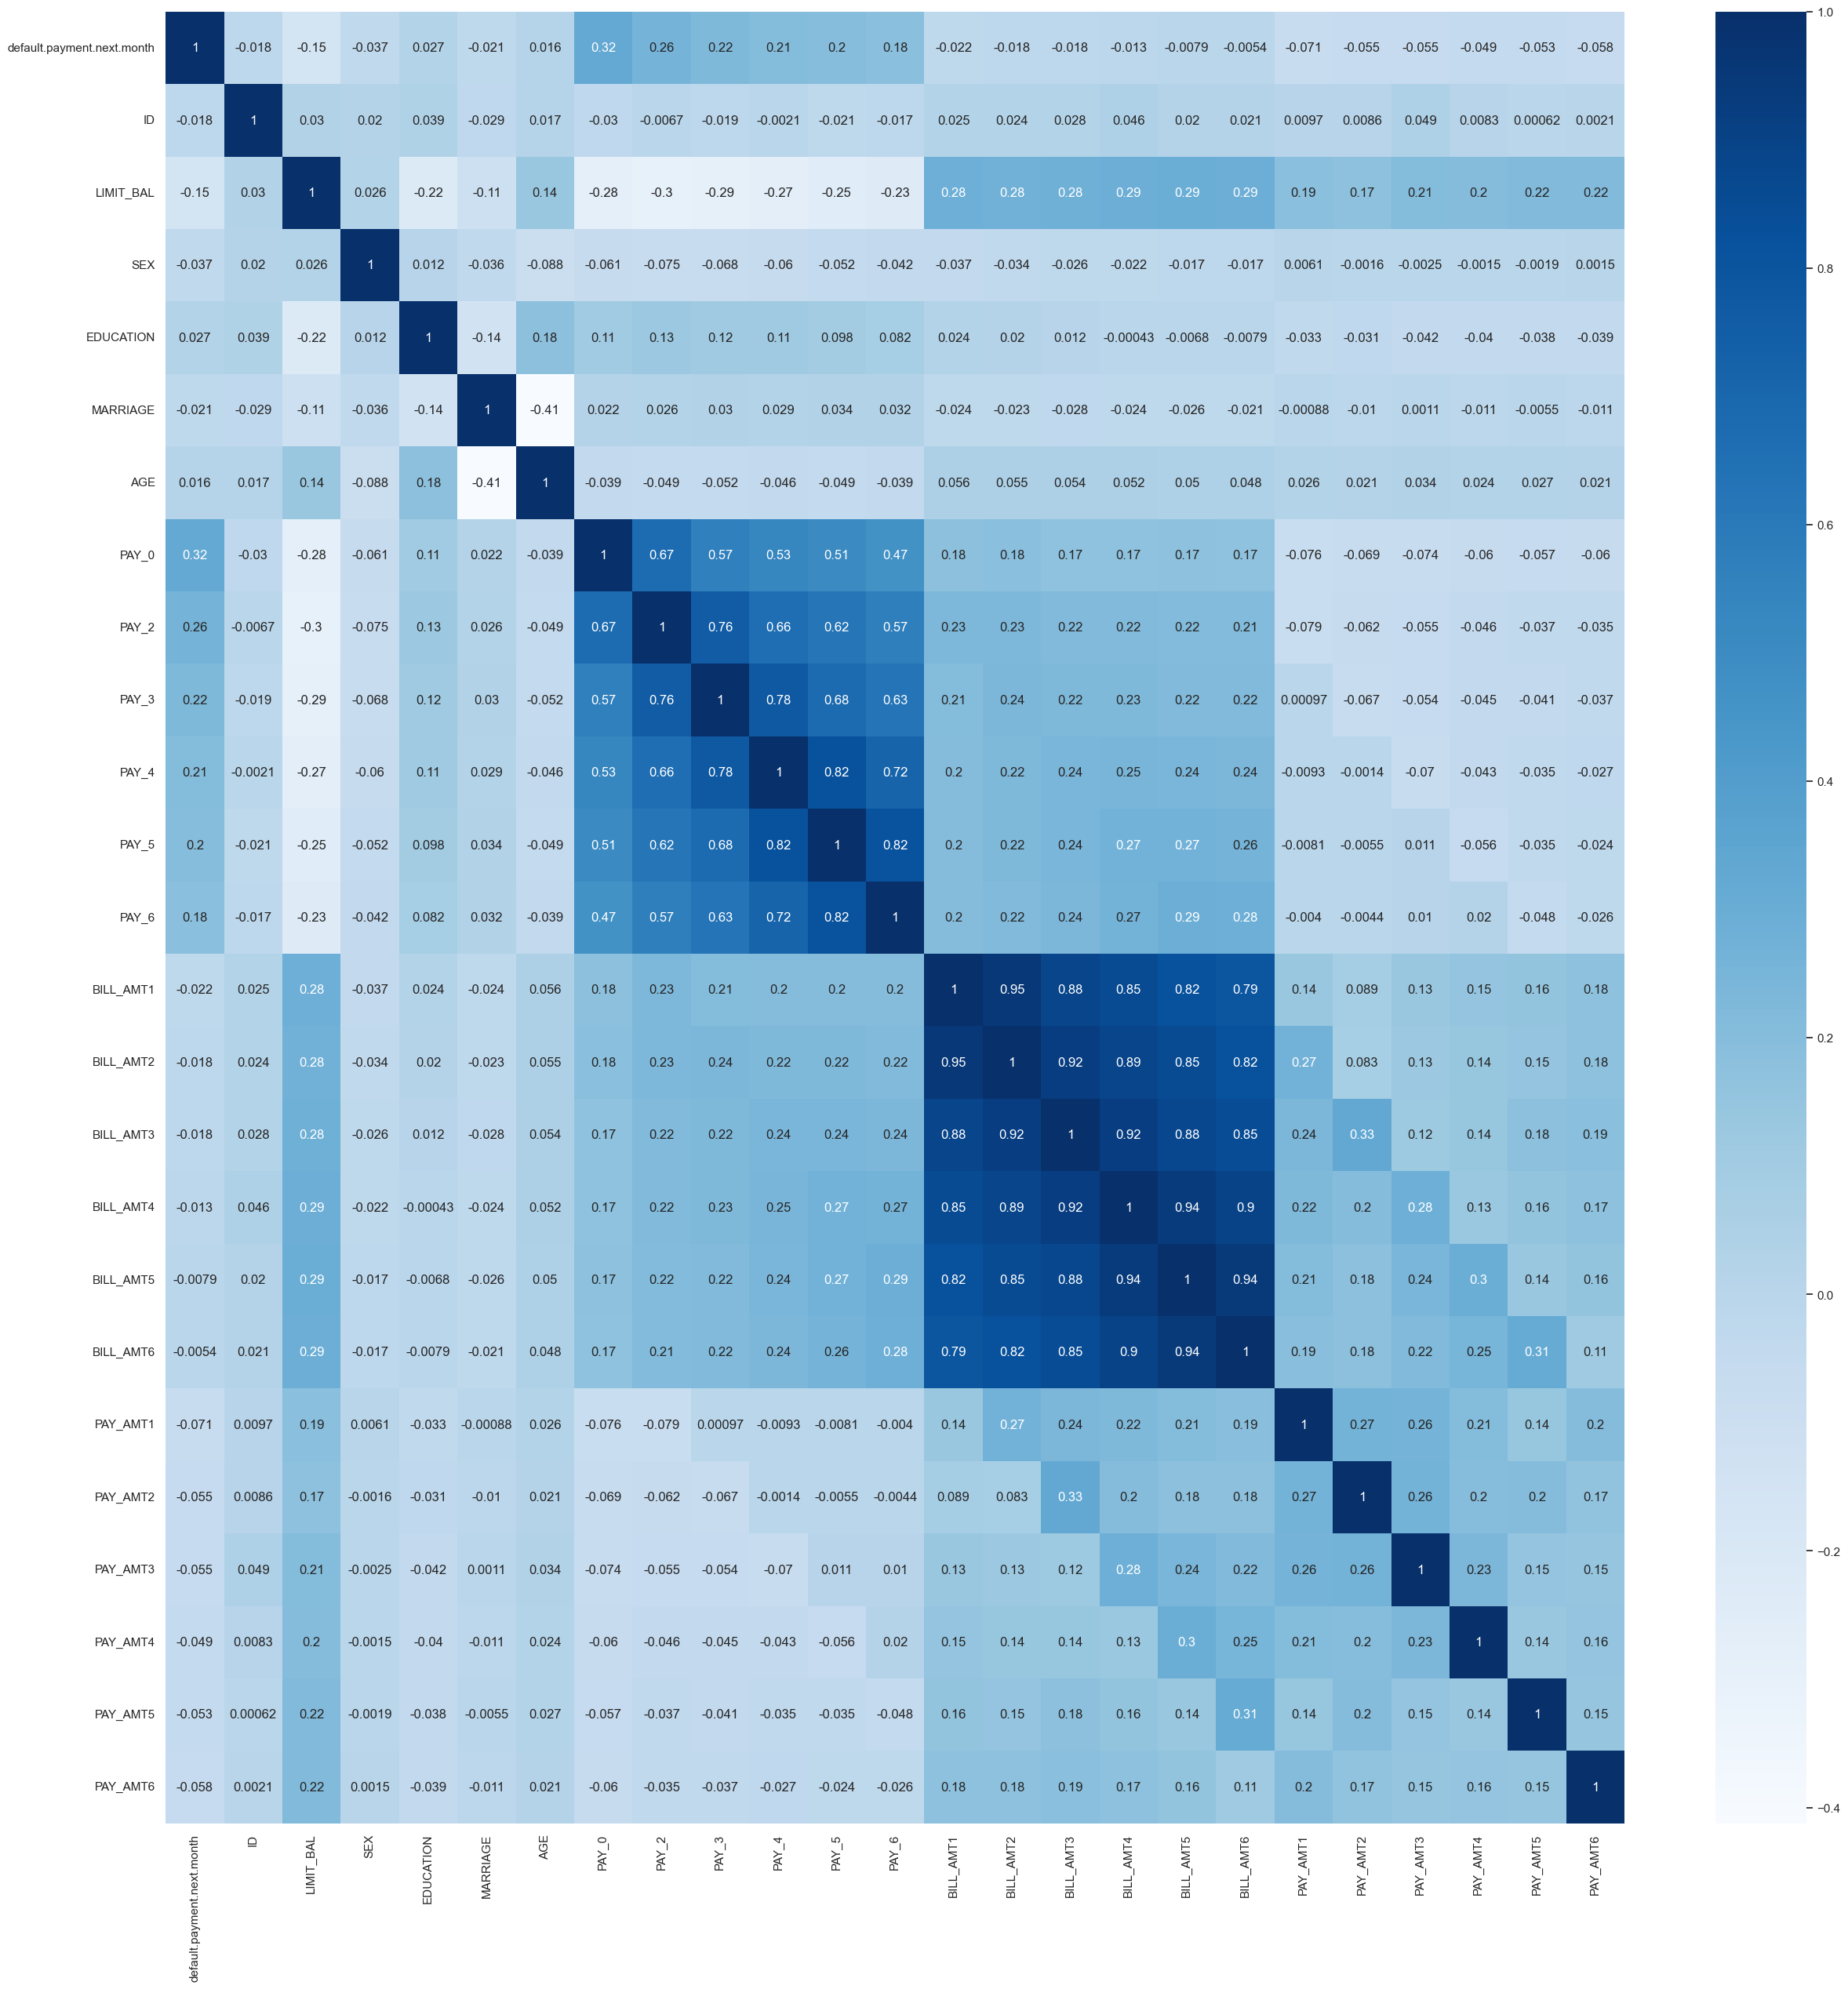

In [23]:
import seaborn as sns
cor = pd.concat((y_train, X_train), axis=1).iloc[:,:30].corr()
plt.figure(figsize=(30,30))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)

I can tell all "PAY_\d" features and "BILL_AMT\d" features are highly correlated.
I can also tell from the scatter plot below.

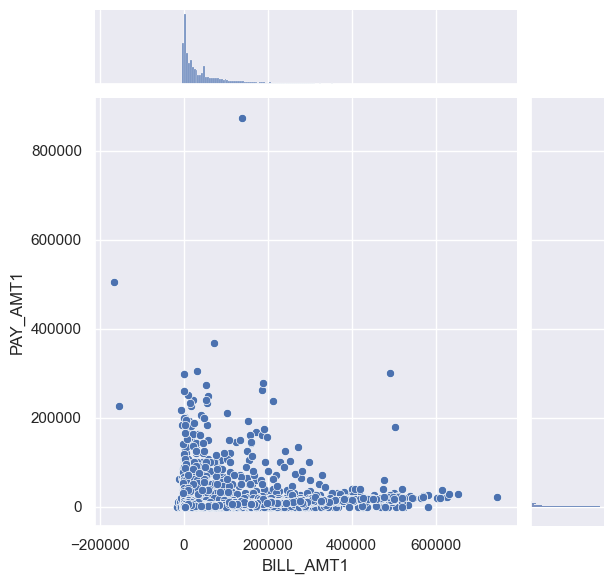

In [24]:
sns.jointplot(x="BILL_AMT1", y="PAY_AMT1", data=train_df)

Graph below represents the frequency of data points within each bin for the corresponding variable.
Based on these histograms, I can observe there are some outliers for features such as 'EDUCATION', 'MARRIAGE', 'PAY\d' features.

array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'LIMIT_BAL'}>,
        <Axes: title={'center': 'SEX'}>,
        <Axes: title={'center': 'EDUCATION'}>,
        <Axes: title={'center': 'MARRIAGE'}>],
       [<Axes: title={'center': 'AGE'}>,
        <Axes: title={'center': 'PAY_0'}>,
        <Axes: title={'center': 'PAY_2'}>,
        <Axes: title={'center': 'PAY_3'}>,
        <Axes: title={'center': 'PAY_4'}>],
       [<Axes: title={'center': 'PAY_5'}>,
        <Axes: title={'center': 'PAY_6'}>,
        <Axes: title={'center': 'BILL_AMT1'}>,
        <Axes: title={'center': 'BILL_AMT2'}>,
        <Axes: title={'center': 'BILL_AMT3'}>],
       [<Axes: title={'center': 'BILL_AMT4'}>,
        <Axes: title={'center': 'BILL_AMT5'}>,
        <Axes: title={'center': 'BILL_AMT6'}>,
        <Axes: title={'center': 'PAY_AMT1'}>,
        <Axes: title={'center': 'PAY_AMT2'}>],
       [<Axes: title={'center': 'PAY_AMT3'}>,
        <Axes: title={'center': 'PAY_AMT4'}>,
        <A

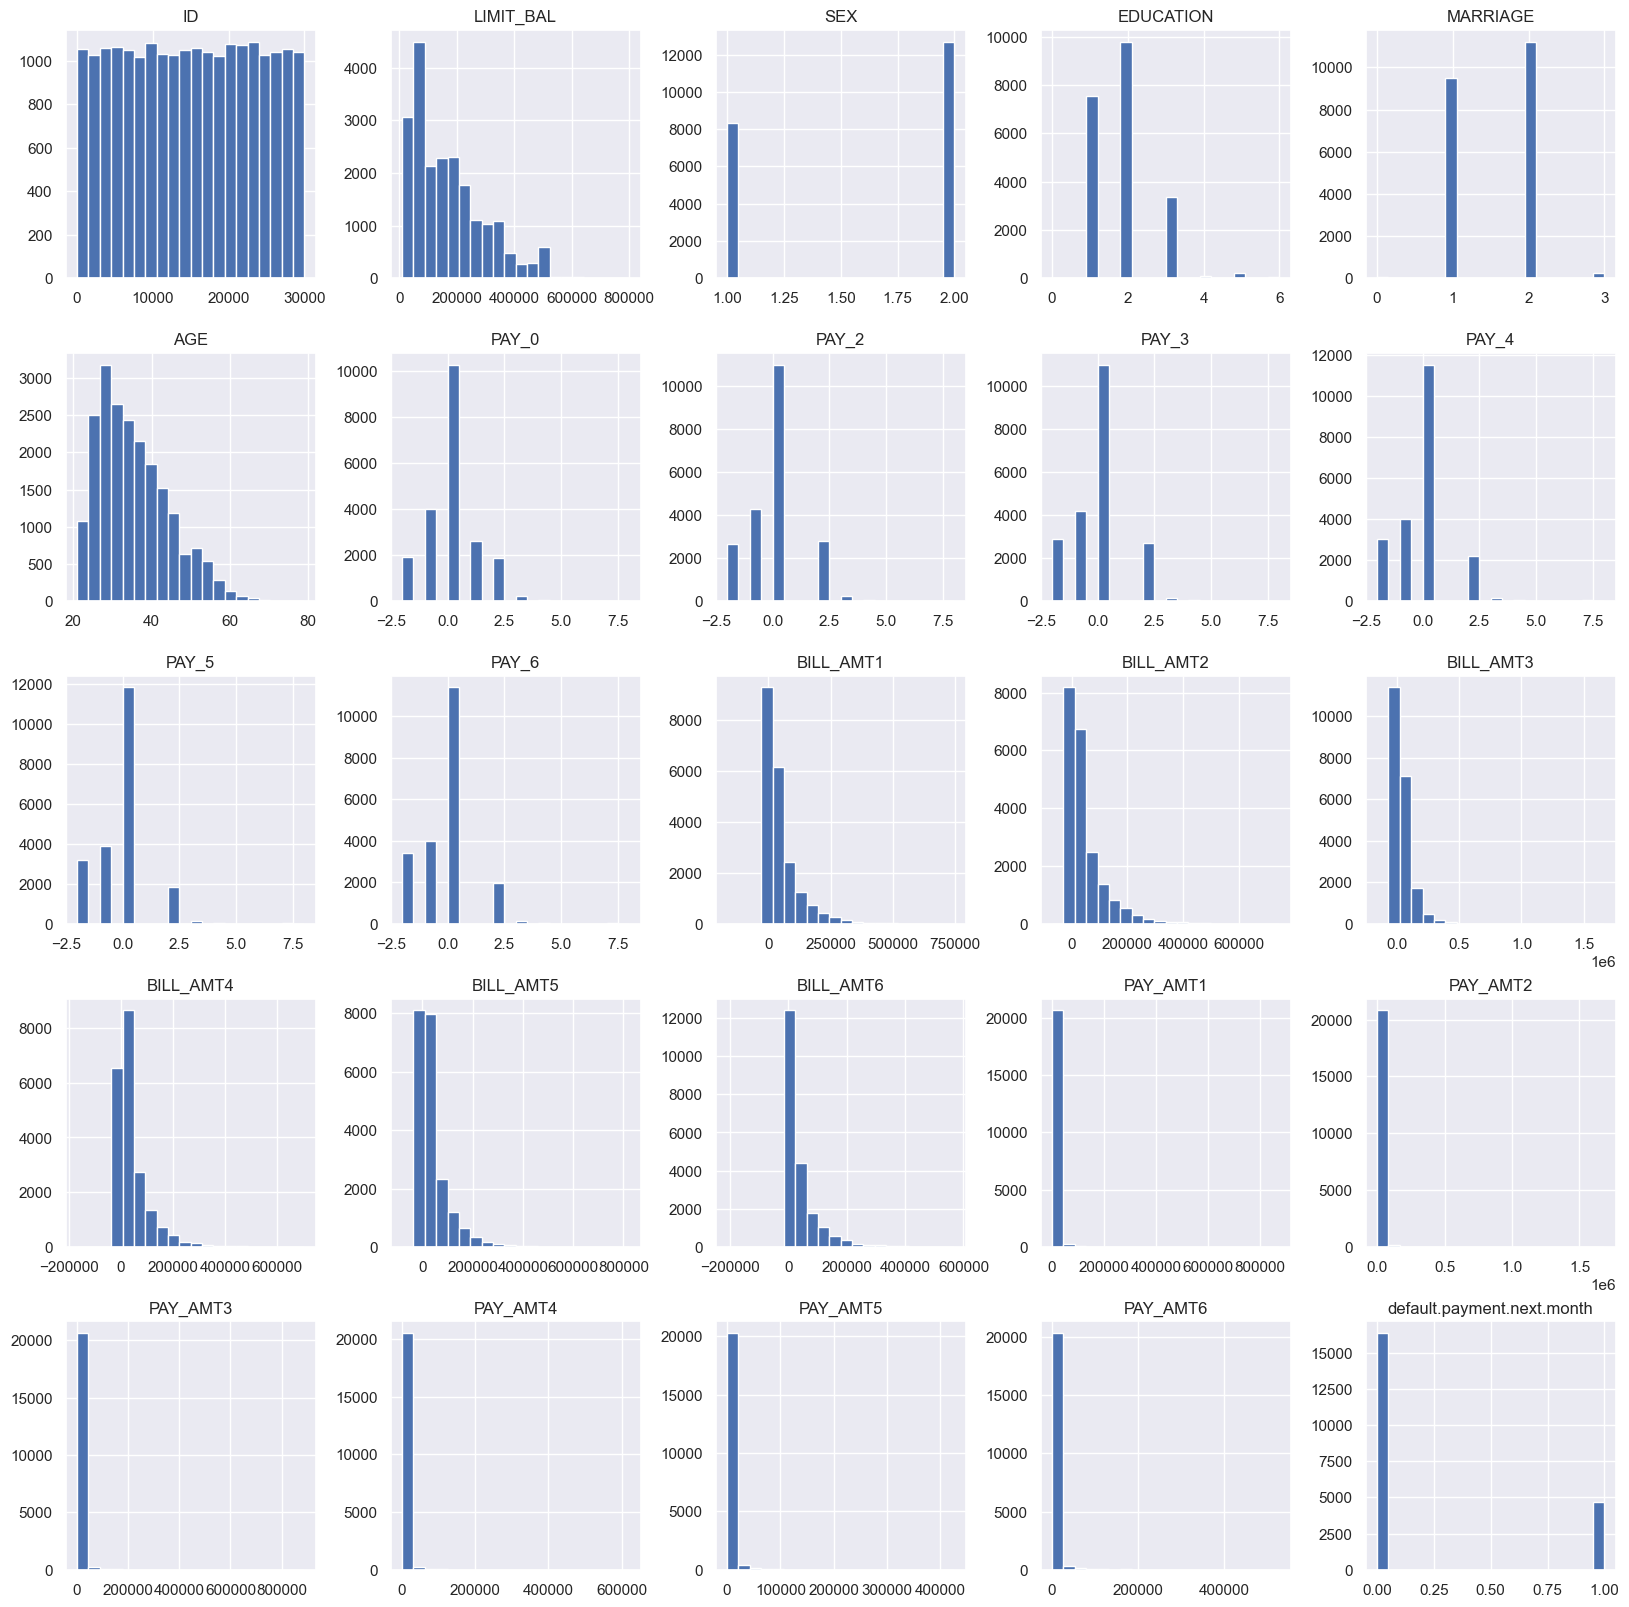

In [25]:
train_df.hist(figsize=(20,20), bins=20)

So far
- I have very few features.
- I have class imbalance and I need to deal with it. I have chosen macro average f1 as our metric where both classes get equal weight.
- The feature ranges are very difficul, so I will need to standardize.
- I have a number of collinear (highly correlated) features. ("PAY\d" and "BILL_AMT\d")
- I have quite a few outliers features ("EDUCATION", "MARRIAGE", "PAY\d").
- The data is a bit messy.
    - What does it mean by education level 5 and 6?
    - What does it mean for PAY_* to be -2? Or 0?

### Preprocessing and Transformations

- First I will identify numeric and categorical features and use make_column_transformer to apply different transformation on different columns.
- make_column_transformer is similar to make_pipeline syntax but there is some convenient.
    - The syntax automatically names each step based on its class.


In [27]:
# exclude ID feature
drop_features = ["ID"]
numeric_features = [
    "LIMIT_BAL",
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4",
    "BILL_AMT5",
    "BILL_AMT6",
    "PAY_AMT1",
    "PAY_AMT2",
    "PAY_AMT3",
    "PAY_AMT4",
    "PAY_AMT5",
    "PAY_AMT6",
    "AGE"
]
binary_features = ["SEX"]
categorical_features = ["EDUCATION", "MARRIAGE"]
target = "default.payment.next.month"

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary"), binary_features),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features)
)

Calculate mean and standard deviation of cross validation


In [30]:
from sklearn.dummy import DummyClassifier

results = {}

# Dummy Classifier
dummy = DummyClassifier(strategy="stratified")
scores = cross_validate(dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric)
mean_scores = pd.DataFrame(scores).mean()
std_scores = pd.DataFrame(scores).std()
out_col = []

for i in range(len(mean_scores)):
    out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

results["dummy"] = pd.Series(data=out_col, index=mean_scores.index)

# Display Results
results_df = pd.DataFrame(results)
print(results_df)


                         dummy
fit_time     0.003 (+/- 0.001)
score_time   0.004 (+/- 0.001)
test_score   0.500 (+/- 0.007)
train_score  0.496 (+/- 0.002)


In [37]:
cross_val_score(dummy, X_train, y_train)

array([0.64833333, 0.66357143, 0.66142857, 0.66333333, 0.65333333])